In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *

#import math tools
import numpy as np
from scipy.linalg import expm

# We import the tools to handle general Graphs
import networkx as nx

# We import plotting tools 
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

import account

# Loading your IBM Q account(s)
IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q-university', group='harvard-lukin', project='phys160')
IBMQ.get_provider(hub='ibm-q-university', group='harvard-lukin', project='phys160')

configrc.store_credentials:WARNING:2020-05-12 10:57:03,340: Credentials already present. Set overwrite=True to overwrite.


<AccountProvider for IBMQ(hub='ibm-q-university', group='harvard-lukin', project='phys160')>

In [1]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

def get_noise(p_meas,p_gate):

    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ["x"]) # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"]) # two qubit gate error is applied to cx gates
        
    return noise_model

In [26]:
noise_model = get_noise(0.0,0.0)

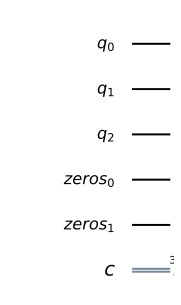

In [80]:
from qiskit import QuantumCircuit, execute, Aer, QuantumRegister

qc0 = QuantumCircuit(3,3,name='0') # initialize circuit with three qubits in the 0 state

qr = QuantumRegister(2,'zeros')
qc0.add_register(qr)
qc0.draw(output='mpl')

In [46]:
qc0.x(qc0.qregs[0]) # flip each 0 to 1
qc0.measure(qc0.qregs[0],qc0.cregs[0]) # measure the qubits


# run the circuit with the noise model and extract the counts
counts = execute( qc0, Aer.get_backend('qasm_simulator'),noise_model=noise_model).result().get_counts()

print(counts)

{'111': 1024}


In [20]:
print(qc0.qregs[0][0])

Qubit(QuantumRegister(3, 'q'), 0)


In [32]:
qc1 = QuantumCircuit(3,3,name='0') # initialize circuit with three qubits in the 0 state
qc1.x(qc1.qregs[0]) # flip each 0 to 1

qc1.measure(qc1.qregs[0],qc1.cregs[0]) # measure the qubits

# run the circuit with th noise model and extract the counts
counts = execute( qc1, Aer.get_backend('qasm_simulator'),noise_model=noise_model).result().get_counts()

print(counts)

{'111': 1024}


In [55]:
from qiskit.ignis.verification.topological_codes import RepetitionCode
from qiskit.ignis.verification.topological_codes import lookuptable_decoding
from qiskit.ignis.verification.topological_codes import GraphDecoder

In [56]:
n = 3
T = 1

code = RepetitionCode(n,T)

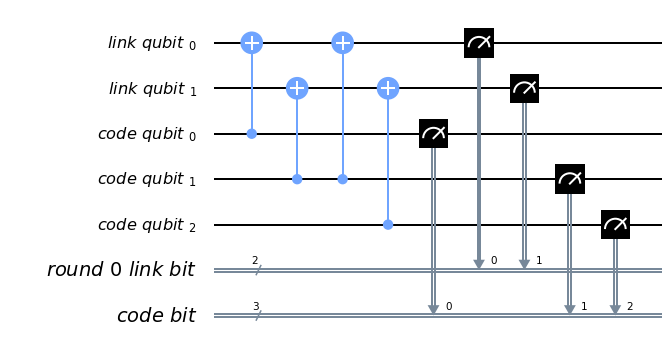

In [57]:
# this bit is just needed to make the labels look nice
for reg in code.circuit['0'].qregs+code.circuit['1'].cregs:
    reg.name = reg.name.replace('_','\ ') + '\ '

code.circuit['0'].draw(output='mpl')

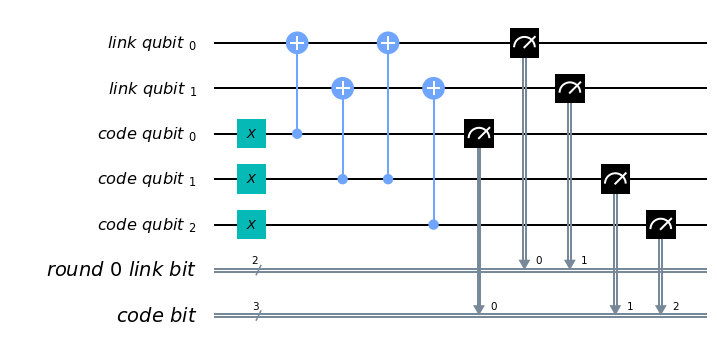

In [58]:
code.circuit['1'].draw(output='mpl')

In [60]:
def get_raw_results(code,noise_model=None):

    circuits = code.get_circuit_list()
    raw_results = {}
    for log in range(2):
        job = execute( circuits[log], Aer.get_backend('qasm_simulator'), noise_model=noise_model)
        raw_results[str(log)] = job.result().get_counts(str(log))
    return raw_results

raw_results = get_raw_results(code)
for log in raw_results:
    print('Logical',log,':',raw_results[log],'\n')

Logical 0 : {'000 00': 1024} 

Logical 1 : {'111 00': 1024} 



In [61]:
code = RepetitionCode(3,1)

noise_model = get_noise(0.05,0.05)

raw_results = get_raw_results(code,noise_model)
for log in raw_results:
    print('Logical',log,':',raw_results[log],'\n')

Logical 0 : {'011 00': 6, '100 00': 61, '010 10': 6, '001 00': 48, '101 00': 2, '111 00': 1, '100 11': 1, '000 11': 7, '001 11': 1, '011 01': 1, '110 01': 1, '000 10': 73, '001 01': 8, '100 01': 8, '100 10': 6, '000 01': 72, '110 00': 6, '010 11': 3, '000 00': 639, '010 01': 19, '010 00': 51, '001 10': 4} 

Logical 1 : {'011 00': 49, '100 00': 1, '010 10': 1, '001 00': 5, '111 11': 8, '101 00': 46, '101 01': 22, '111 00': 641, '110 11': 2, '000 11': 1, '110 01': 12, '001 11': 2, '011 01': 2, '111 10': 59, '001 01': 2, '100 01': 2, '100 10': 1, '101 11': 18, '110 00': 41, '011 11': 1, '011 10': 19, '010 11': 2, '101 10': 5, '110 10': 7, '010 01': 1, '010 00': 5, '111 01': 69} 



In [62]:
circuits = code.get_circuit_list()
table_results = {}
for log in range(2):
    job = execute( circuits[log], Aer.get_backend('qasm_simulator'), noise_model=noise_model, shots=10000 )
    table_results[str(log)] = job.result().get_counts(str(log))

In [63]:
P = lookuptable_decoding(raw_results,table_results)
print('P =',P)

P = {'0': 0.0171, '1': 0.024}


In [121]:
qc = QuantumCircuit(1) # Create a quantum circuit with one qubit
norm = np.linalg.norm([1,1])
initial_state = [1,1]/norm   # Define initial_state as |1>
qc.initialize(initial_state, 0) # Apply initialisation operation to the 0th qubit


(<qiskit.extensions.quantum_initializer.initializer.Initialize object at 0x1a2dd6b3d0>, [Qubit(QuantumRegister(1, 'q'), 0)], [])


In [73]:
backend = Aer.get_backend('statevector_simulator') # Tell Qiskit how to simulate our circuit

In [74]:
result = execute(qc,backend).result() # Do the simulation, returning the result

In [75]:
out_state = result.get_statevector()
print(out_state) # Display the output state vector

[0.70710678+0.j 0.70710678+0.j]


In [171]:
#qc is a quantum circuit with 1 qubit, a and b are the coefficients of 0 and 1 in the state
def initialize_state(qc, a, b): 
    norm = np.linalg.norm([a, b])
    initial_state = [a, b]/norm
    qc.initialize(initial_state, 0)

In [172]:
#qc would be a quantum circuit with 1 qubit
def encode_qubit(qc):
    qr = QuantumRegister(2)
    qc.add_register(qr)
    qc.cx(qc.qregs[0],qr[0])
    qc.cx(qc.qregs[0],qr[1])

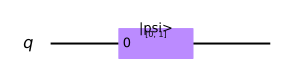

In [173]:
qc3 = QuantumCircuit(1)
initialize_state(qc3, 0, 1)
qc3.draw(output='mpl')

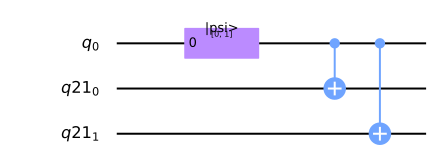

In [174]:
encode_qubit(qc3)
qc3.draw(output='mpl')

In [175]:
def show_state(qc):
    backend = Aer.get_backend('statevector_simulator') # Tell Qiskit how to simulate our circuit
    result = execute(qc,backend).result() # Do the simulation, returning the result
    out_state = result.get_statevector()
    print(out_state) # Display the output state vector

In [202]:
#check error on encoded 3-qubit system qc
def check_for_error(qc):
    qr = QuantumRegister(2)
    qc.add_register(qr)
    print(qc.qregs[0])
    print(qr[0])
    qc.cx(qc.qregs[0],qr[0])
    qc.cx(qc.qregs[1][0],qr[0])
    qc.cx(qc.qregs[1][0],qr[1])
    qc.cx(qc.qregs[1][1],qr[1])

QuantumRegister(1, 'q')
Qubit(QuantumRegister(2, 'q34'), 0)


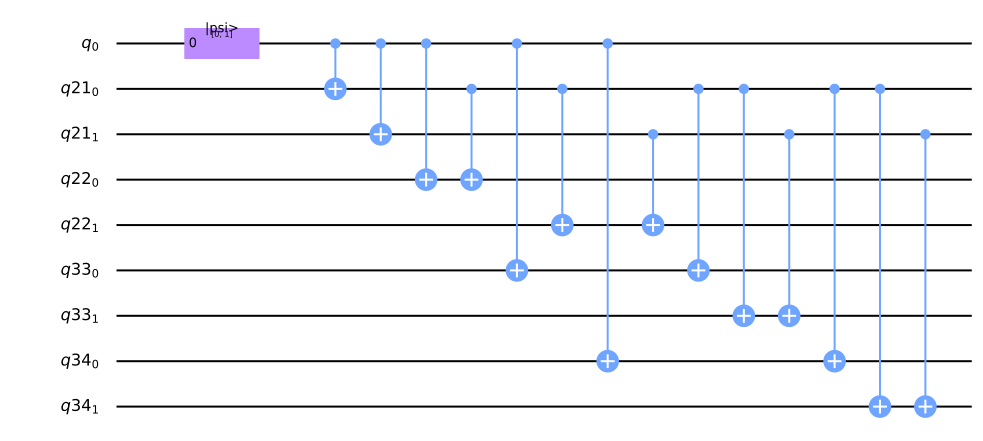

In [203]:
check_for_error(qc3)
qc3.draw(output='mpl')

In [236]:
# encode initial state
from qiskit import *
# encode initial state
def encode(initial_state):
    qr = QuantumRegister(5)
    cr = ClassicalRegister(2)
    qc = QuantumCircuit(qr, cr)
    qc.initialize(initial_state, 0)
    qc.cx(qr[0],qr[1])
    qc.cx(qr[0],qr[2])
    return qc

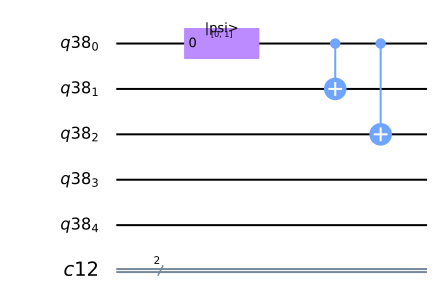

In [237]:
qc = encode([0,1])
qc.draw(output='mpl')

In [238]:
print(qc.qregs[0])

QuantumRegister(5, 'q38')


In [241]:
def single_qubit_op(qc, gate, target):
    qr = qc.qregs[0]
    qc.x(qr[target])

In [242]:
single_qubit_op(qc, qc.x, 0)

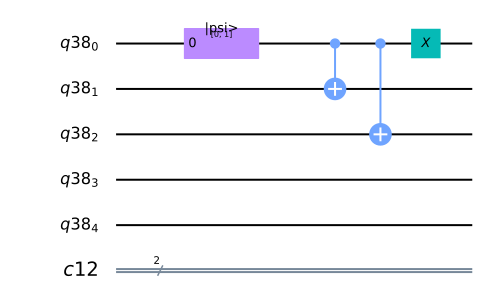

In [243]:
qc.draw(output='mpl')

In [235]:
print(qc.data)

[(<qiskit.extensions.quantum_initializer.initializer.Initialize object at 0x1a2f19d350>, [Qubit(QuantumRegister(5, 'q37'), 0)], []), (<qiskit.extensions.standard.x.CXGate object at 0x1a2f19dd90>, [Qubit(QuantumRegister(5, 'q37'), 0), Qubit(QuantumRegister(5, 'q37'), 1)], []), (<qiskit.extensions.standard.x.CXGate object at 0x1a2f19de50>, [Qubit(QuantumRegister(5, 'q37'), 0), Qubit(QuantumRegister(5, 'q37'), 2)], []), (<qiskit.extensions.standard.x.XGate object at 0x1a2f1d3290>, [Qubit(QuantumRegister(5, 'q37'), 0)], []), (<qiskit.extensions.standard.x.XGate object at 0x1a2f2f6690>, [Qubit(QuantumRegister(5, 'q37'), 0)], [])]


In [244]:
# encode initial state, returns a quantum circuit
def encode(initial_state):
    qr = QuantumRegister(5) # 5 lines, 3 are for encoding (0,1,2), 2 are ancillary qubits (3,4)
    cr = ClassicalRegister(2) # 2 classical registers for measurement outcomes
    qc = QuantumCircuit(qr, cr)
    qc.initialize(initial_state, 0)
    qc.cx(qr[0],qr[1])
    qc.cx(qr[0],qr[2])
    return qc

In [245]:
# after performing an operation on the encoded state, correct the error
def correct_error(qc):
    qr = qc.qregs[0]
    cr = qc.cregs[0]
    
    # initialize the ancillary qubits to 0
    qc.initialize([1,0], 3)
    qc.initialize([1,0], 4)
    
    # attach CNOTs
    qc.cx(qr[0], qr[3])
    qc.cx(qr[1], qr[3])
    
    qc.cx(qr[0], qr[4])
    qc.cx(qr[2], qr[4])
    
    # measure the ancillary qubits
    qc.measure(qr[3], cr[0]) # first ancillary qubit's measurement in first classical register
    qc.measure(qr[4], cr[1]) # second ancillary qubit's measurement in second classical register
    
    # apply X gate to correct error based on measurement outcomes
    qc.x(qr[0]).c_if(cr, 3) # if the classical register says |11>, or "3", then apply on qb 0
    qc.x(qr[1]).c_if(cr, 2) # |10> means qb 2 has the error
    qc.x(qr[2]).c_if(cr, 1) # |01> means qb 3 has the error
    

In [246]:
qc = encode([1,0])

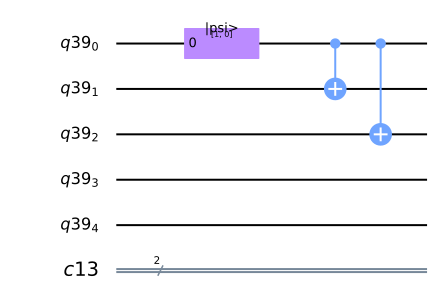

In [247]:
qc.draw(output='mpl')

In [248]:
correct_error(qc)

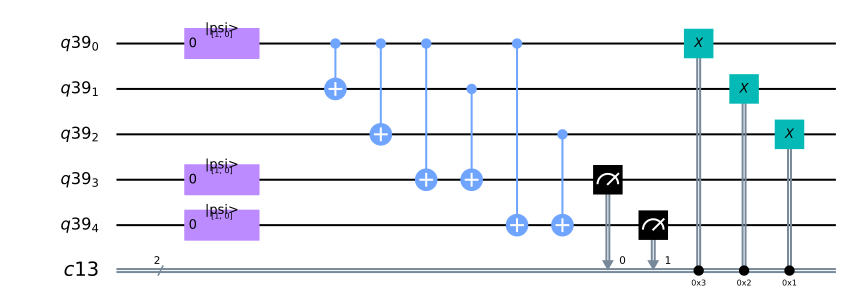

In [249]:
qc.draw(output='mpl')

In [250]:
qc.data

[(<qiskit.extensions.quantum_initializer.initializer.Initialize object at 0x1a2f538090>, [Qubit(QuantumRegister(5, 'q39'), 0)], []), (<qiskit.extensions.standard.x.CXGate object at 0x1a2f538690>, [Qubit(QuantumRegister(5, 'q39'), 0), Qubit(QuantumRegister(5, 'q39'), 1)], []), (<qiskit.extensions.standard.x.CXGate object at 0x1a2f5385d0>, [Qubit(QuantumRegister(5, 'q39'), 0), Qubit(QuantumRegister(5, 'q39'), 2)], []), (<qiskit.extensions.quantum_initializer.initializer.Initialize object at 0x1a2f62d990>, [Qubit(QuantumRegister(5, 'q39'), 3)], []), (<qiskit.extensions.quantum_initializer.initializer.Initialize object at 0x1a2f646410>, [Qubit(QuantumRegister(5, 'q39'), 4)], []), (<qiskit.extensions.standard.x.CXGate object at 0x1a2f5dba10>, [Qubit(QuantumRegister(5, 'q39'), 0), Qubit(QuantumRegister(5, 'q39'), 3)], []), (<qiskit.extensions.standard.x.CXGate object at 0x1a2f476390>, [Qubit(QuantumRegister(5, 'q39'), 1), Qubit(QuantumRegister(5, 'q39'), 3)], []), (<qiskit.extensions.standar

In [255]:
for i in range(len(qc.data)):
    print(qc.data[i])

(<qiskit.extensions.quantum_initializer.initializer.Initialize object at 0x1a2f538090>, [Qubit(QuantumRegister(5, 'q39'), 0)], [])
(<qiskit.extensions.standard.x.CXGate object at 0x1a2f538690>, [Qubit(QuantumRegister(5, 'q39'), 0), Qubit(QuantumRegister(5, 'q39'), 1)], [])
(<qiskit.extensions.standard.x.CXGate object at 0x1a2f5385d0>, [Qubit(QuantumRegister(5, 'q39'), 0), Qubit(QuantumRegister(5, 'q39'), 2)], [])
(<qiskit.extensions.quantum_initializer.initializer.Initialize object at 0x1a2f62d990>, [Qubit(QuantumRegister(5, 'q39'), 3)], [])
(<qiskit.extensions.quantum_initializer.initializer.Initialize object at 0x1a2f646410>, [Qubit(QuantumRegister(5, 'q39'), 4)], [])


In [254]:
for i in range(9):
    qc.data.pop(len(qc.data)-1)

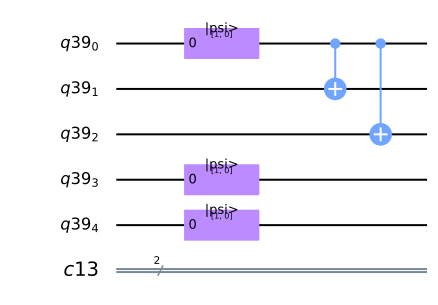

In [256]:
qc.draw(output='mpl')

In [257]:
# encode initial state, returns a quantum circuit
def encode(initial_state):
    qr = QuantumRegister(5) # 5 lines, 3 are for encoding (0,1,2), 2 are ancillary qubits (3,4)
    cr = ClassicalRegister(2) # 2 classical registers for measurement outcomes
    qc = QuantumCircuit(qr, cr)
    qc.initialize(initial_state, 0)
    qc.cx(qr[0],qr[1])
    qc.cx(qr[0],qr[2])
    return qc

In [258]:
# after performing an operation on the encoded state, correct the error
def correct_error(qc):
    qr = qc.qregs[0]
    cr = qc.cregs[0]
    
    # initialize the ancillary qubits to 0
    qc.initialize([1,0], 3)
    qc.initialize([1,0], 4)
    
    # attach CNOTs
    qc.cx(qr[0], qr[3])
    qc.cx(qr[1], qr[3])
    
    qc.cx(qr[0], qr[4])
    qc.cx(qr[2], qr[4])
    
    # measure the ancillary qubits
    qc.measure(qr[3], cr[0]) # first ancillary qubit's measurement in first classical register
    qc.measure(qr[4], cr[1]) # second ancillary qubit's measurement in second classical register
    
    # apply X gate to correct error based on measurement outcomes
    qc.x(qr[0]).c_if(cr, 3) # if the classical register says |11>, or "3", then apply on qb 0
    qc.x(qr[1]).c_if(cr, 2) # |10> means qb 2 has the error
    qc.x(qr[2]).c_if(cr, 1) # |01> means qb 3 has the error
    
    #remove the gates that were just added
    for i in range(9):
        qc.data.pop(len(qc.data)-1)

In [259]:
qc = encode([0,1])
correct_error(qc)

In [261]:
qc.draw()

┌─────────────────┐          
q40_0: ┤ Initialize(0,1) ├──■────■──
       └─────────────────┘┌─┴─┐  │  
q40_1: ───────────────────┤ X ├──┼──
                          └───┘┌─┴─┐
q40_2: ────────────────────────┤ X ├
       ┌─────────────────┐     └───┘
q40_3: ┤ Initialize(1,0) ├──────────
       ├─────────────────┤          
q40_4: ┤ Initialize(1,0) ├──────────
       └─────────────────┘          
c14_0: ═════════════════════════════
                                    
c14_1: ═════════════════════════════

In [263]:
for i in range(len(qc.data)):
    print(qc.data[i])

(<qiskit.extensions.quantum_initializer.initializer.Initialize object at 0x1a2ee194d0>, [Qubit(QuantumRegister(5, 'q40'), 0)], [])
(<qiskit.extensions.standard.x.CXGate object at 0x1a2ee19590>, [Qubit(QuantumRegister(5, 'q40'), 0), Qubit(QuantumRegister(5, 'q40'), 1)], [])
(<qiskit.extensions.standard.x.CXGate object at 0x1a2ee19150>, [Qubit(QuantumRegister(5, 'q40'), 0), Qubit(QuantumRegister(5, 'q40'), 2)], [])
(<qiskit.extensions.quantum_initializer.initializer.Initialize object at 0x1a2ee19290>, [Qubit(QuantumRegister(5, 'q40'), 3)], [])
(<qiskit.extensions.quantum_initializer.initializer.Initialize object at 0x1a2ee19750>, [Qubit(QuantumRegister(5, 'q40'), 4)], [])


In [2]:
class BitFlip:

    def __init__(self, initial_state = [1,0]):
        self.initial_state = initial_state / np.linalg.norm(initial_state)
        self.qr = QuantumRegister(5)
        self.cr = ClassicalRegister(5)
        self.qc = QuantumCircuit(self.qr, self.cr)
        self.qc.initialize(self.initial_state, 0)
        self.qc.cx(self.qr[0], self.qr[1])
        self.qc.cx(self.qr[0], self.qr[2])
        self.results = []

    def draw(self):
        print(self.qc.draw())

    def x_gate(self):
        self.qc.x(self.qr[0])
        self.qc.x(self.qr[1])
        self.qc.x(self.qr[2])

    def z_gate(self):
        self.qc.z(self.qr[0])
        self.qc.z(self.qr[1])
        self.qc.z(self.qr[2])

    def flip_one(self):
        self.qc.x(self.qr[1])

    def add_error(self, p):
        # with probability p, each of the 3 encoded bits will be flipped
        for i in range(3):
            if (random() < p):
                self.qc.x(self.qr[i])

    def run_simulation(self, shots = 8192, error_prob = 0, target_state = '000'):
        # add noise
        error_1 = noise.depolarizing_error(error_prob, 1)
        noise_model = noise.NoiseModel()
        noise_model.add_all_qubit_quantum_error(error_1, ['x','z'])

        # run simulation
        self.qc.measure([0,1,2], [4,3,2])
        emulator = Aer.get_backend('qasm_simulator')
        job = execute(self.qc, emulator, noise_model=noise_model, shots=shots)
        hist = job.result().get_counts()
        # print(hist)

        # print statistics
        successes = 0
        first_three = [n[0:3] for n in list(hist.keys())]
        for i in range(len(first_three)):
            if (first_three[i] == target_state):
                successes += hist.get(list(hist.keys())[i])
        # print("success rate:", successes/shots)
        return successes/shots


    def run_real_device(self, device_name, shots = 8192, target_state = '000'):
        self.qc.measure([0,1,2], [4,3,2])
        device = provider.get_backend(device_name)
        job = execute(self.qc, device, shots=shots)
        hist = job.result().get_counts()
        print(hist)

        # print statistics
        successes = 0
        first_three = [n[0:3] for n in list(hist.keys())]
        for i in range(len(first_three)):
            if (first_three[i] == target_state):
                successes += hist.get(list(hist.keys())[i])
        # print("success rate:", successes/shots)
        return successes/shots

    # after performing an operation on the encoded state, correct the error
    def correct_error(self):
        # qr = qc.qregs[0]
        # cr = qc.cregs[0]
        
        # initialize the ancillary qubits to 0
        self.qc.initialize([1,0], 3)
        self.qc.initialize([1,0], 4)
        
        # attach CNOTs
        self.qc.cx(self.qr[0], self.qr[3])
        self.qc.cx(self.qr[1], self.qr[3])
        
        self.qc.cx(self.qr[0], self.qr[4])
        self.qc.cx(self.qr[2], self.qr[4])
        
        # measure the ancillary qubits
        self.qc.measure(self.qr[3], self.cr[0]) # first ancillary qubit's measurement in classical register 0
        self.qc.measure(self.qr[4], self.cr[1]) # second ancillary qubit's measurement in classical register 1
        
        # apply X gate to correct error based on measurement outcomes
        self.qc.x(self.qr[0]).c_if(self.cr, 3) # if the classical register says |11>, or "3", then apply on qb 0
        self.qc.x(self.qr[2]).c_if(self.cr, 2) # |10> means qb 3 has the error
        self.qc.x(self.qr[1]).c_if(self.cr, 1) # |01> means qb 1 has the error

    def test_correction(self):
        self.qc.measure([0,1,2], [4,3,2])
        emulator = Aer.get_backend('qasm_simulator')
        job = execute(self.qc, emulator, shots=1)
        hist = job.result().get_counts()
        result = list(hist.keys())[0][0:3]
        # print(result)
        self.results.append(result)
        
    #removes the last 9 gates (use if the last thing you did was correct_error())
    def remove_correction_gates(self): 
        for _ in range(9):
            self.qc.data.pop(len(self.qc.data)-1)
    
    #removes all but the gates added during initialization
    def reset(self): 
        while (len(self.qc.data) > 3):
            self.qc.data.pop(len(self.qc.data) - 1)

    def get_accuracy(self):
        return self.results.count('000')/len(self.results)

In [7]:
from qiskit import QuantumCircuit, execute, Aer, IBMQ, QuantumRegister, ClassicalRegister
qc = BitFlip()
qc.flip_one()
qc.correct_error()
qc.draw()

      ┌─────────────────┐                                          ┌───┐ »
q1_0: ┤ initialize(1,0) ├──■────■─────────■─────────■──────────────┤ X ├─»
      └─────────────────┘┌─┴─┐  │  ┌───┐  │         │              └─┬─┘ »
q1_1: ───────────────────┤ X ├──┼──┤ X ├──┼────■────┼────────────────┼───»
                         └───┘┌─┴─┐└───┘  │    │    │                │   »
q1_2: ────────────────────────┤ X ├───────┼────┼────┼────■───────────┼───»
      ┌─────────────────┐     └───┘     ┌─┴─┐┌─┴─┐  │    │  ┌─┐      │   »
q1_3: ┤ initialize(1,0) ├───────────────┤ X ├┤ X ├──┼────┼──┤M├──────┼───»
      ├─────────────────┤               └───┘└───┘┌─┴─┐┌─┴─┐└╥┘┌─┐   │   »
q1_4: ┤ initialize(1,0) ├─────────────────────────┤ X ├┤ X ├─╫─┤M├───┼───»
      └─────────────────┘                         └───┘└───┘ ║ └╥┘┌──┴──┐»
c1_0: ═══════════════════════════════════════════════════════╩══╬═╡     ╞»
                                                                ║ │     │»
c1_1: ═══════════════════

In [2]:
qr = QuantumRegister(5)
cr = ClassicalRegister(2)
qc = QuantumCircuit(qr,cr)
qc.cx(qr[0],qr[1])
qc.cx(qr[1],qr[2])
qc.barrier()
qc.x(qr[0])
qc.barrier()
qc.cx(qr[0],qr[3])
qc.cx(qr[1],qr[3])
qc.cx(qr[0],qr[4])
qc.cx(qr[2],qr[4])
qc.measure(qr[3],cr[0])
qc.measure(qr[4],cr[1])
qc.x(qr[0]).c_if(cr, 3)
qc.x(qr[2]).c_if(cr, 2)
qc.x(qr[1]).c_if(cr, 1)
qc.draw()

░ ┌───┐ ░                            ┌───┐               
q0_0: ──■────────░─┤ X ├─░───■─────────■──────────────┤ X ├───────────────
      ┌─┴─┐      ░ └───┘ ░   │         │              └─┬─┘         ┌───┐ 
q0_1: ┤ X ├──■───░───────░───┼────■────┼────────────────┼───────────┤ X ├─
      └───┘┌─┴─┐ ░       ░   │    │    │                │    ┌───┐  └─┬─┘ 
q0_2: ─────┤ X ├─░───────░───┼────┼────┼────■───────────┼────┤ X ├────┼───
           └───┘ ░       ░ ┌─┴─┐┌─┴─┐  │    │  ┌─┐      │    └─┬─┘    │   
q0_3: ───────────░───────░─┤ X ├┤ X ├──┼────┼──┤M├──────┼──────┼──────┼───
                 ░       ░ └───┘└───┘┌─┴─┐┌─┴─┐└╥┘┌─┐   │      │      │   
q0_4: ───────────░───────░───────────┤ X ├┤ X ├─╫─┤M├───┼──────┼──────┼───
                 ░       ░           └───┘└───┘ ║ └╥┘┌──┴──┐┌──┴──┐┌──┴──┐
c0_0: ══════════════════════════════════════════╩══╬═╡     ╞╡     ╞╡     ╞
                                                   ║ │ = 3 ││ = 2 ││ = 1 │
c0_1: ═════════════════════════════════════════════╩═╡     ╞╡     ╞╡     ╞
                                                     └─────┘└─────┘└─────┘